## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
import time as t
from termcolor import colored

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Time series
# from fbprophet import Prophet

#Regression imports
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve


#Nice to have
from sklearn.pipeline import make_pipeline

#Geography magic
import geocoder
import googlemaps
import geopy.distance as gd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import fiona
import pysal as ps
from pysal.contrib.viz import mapping as maps
# import contextily as ctx

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6
rcParams.update({'font.size': 14})

### Load all the data into an SQL database

In [3]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides_clean (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare FLOAT,
#                             tips FLOAT,
#                             tolls FLOAT,
#                             extras FLOAT,
#                             trip_total FLOAT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2015.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [8]:
# taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
# weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                --TR.fare,
                                --TR.tolls,
                                CASE WHEN TR.tolls IS NULL THEN TR.fare ELSE TR.fare + TR.tolls END as fare_with_tolls,
                                --TR.tips,
                                --TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-01-01' AND '2016-02-28';""" #'2017-07-31'

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [11]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [12]:
taxi_weather_df = sql_load
# taxi_weather_df = sql_load[sql_load['trip_start_timestamp'] <= '2016-12-31 23:59:59']
# test_set_jan = sql_load[(sql_load['trip_start_timestamp'] >= '2017-01-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-01-31 23:59:59')]
# test_set_feb = sql_load[(sql_load['trip_start_timestamp'] >= '2017-02-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-02-28 23:59:59')]
# test_set_mar = sql_load[(sql_load['trip_start_timestamp'] >= '2017-03-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_apr = sql_load[(sql_load['trip_start_timestamp'] >= '2017-04-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-04-30 23:59:59')]
# test_set_may = sql_load[(sql_load['trip_start_timestamp'] >= '2017-05-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_jun = sql_load[(sql_load['trip_start_timestamp'] >= '2017-06-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-06-30 23:59:59')]
# test_set_jul = sql_load[(sql_load['trip_start_timestamp'] >= '2017-07-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]

In [13]:
# taxi_weather_df = sql_load.sample(n=75000, random_state=42)

In [14]:
taxi_weather_df.describe()

,trip_seconds,trip_miles,fare_with_tolls,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
count,1.984338e+07,1.984637e+07,1.984630e+07,1.709229e+07,1.709229e+07,1.680043e+07,1.680043e+07,1.984660e+07,1.984660e+07,1.984660e+07,1.984660e+07,1.984660e+07
mean,7.672117e+02,3.396201e+00,1.389773e+01,4.190086e+01,-8.765908e+01,4.190089e+01,-8.765378e+01,9.746638e+00,5.261917e+01,4.426738e-01,2.585934e-03,3.020366e-03
std,1.060590e+03,2.262366e+01,2.542274e+01,3.776937e-02,7.354971e-02,3.786307e-02,5.911833e-02,3.765608e+00,1.985110e+01,4.967028e-01,5.078629e-02,5.487480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,4.166014e+01,-8.791362e+01,4.166014e+01,-8.791362e+01,3.130000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+02,1.000000e-01,6.250000e+00,4.188099e+01,-8.765588e+01,4.188099e+01,-8.765600e+01,6.930000e+00,3.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.400000e+02,1.100000e+00,8.500000e+00,4.189251e+01,-8.763275e+01,4.189251e+01,-8.763275e+01,9.170000e+00,5.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.000000e+02,2.700000e+00,1.425000e+01,4.190586e+01,-8.762615e+01,4.191462e+01,-8.762621e+01,1.208000e+01,7.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00
max,8.639900e+04,3.353100e+03,9.999000e+03,4.202122e+01,-8.753490e+01,4.202122e+01,-8.753490e+01,2.662000e+01,8.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00


> Original number of records for 1st-15th February 2016: **831,790**  
> Original number of records for the whole of 2016: **19,846,602**

In [ ]:
print('Total number of taxi trips (in mln):', str(round(taxi_weather_df['fare_with_tolls'].count() / 10**6)))
print('Total $ spent on taxi trips (in mln):', str(round(taxi_weather_df['fare_with_tolls'].sum() / 10**6)))
print('Total number of years of taxi trips:', str(round(taxi_weather_df['trip_seconds'].sum() / 60 / 60 / 24 / 365, 0)))

In [ ]:
#Let's explore the dataset
null_records = sample_150[(taxi_weather_df['pickup_centroid_latitude'].isnull()) | (taxi_weather_df['pickup_centroid_longitude'].isnull()) | 
                (taxi_weather_df['dropoff_centroid_latitude'].isnull()) | (taxi_weather_df['dropoff_centroid_longitude'].isnull()) | 
                (taxi_weather_df['trip_seconds'].isnull()) | (taxi_weather_df['trip_miles'].isnull()) | 
                (taxi_weather_df['fare_with_tolls'].isnull())]['trip_start_timestamp'].count()

print(f'There are {null_records} records with a null value in at least one of the fields mentioned above.')

## Sweeping time!

In [ ]:
taxi_weather_df.head()

In [15]:
#Change payment type to boolean
taxi_weather_df['payment_type'] = pd.Categorical(taxi_weather_df['payment_type'])

In [16]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_clean = taxi_weather_df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude'
                                                    , 'dropoff_centroid_longitude', 'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [ ]:
taxi_weather_clean.head(2)

In [ ]:
# print(taxi_weather_clean.groupby(['fog'])['fog'].count(), '\n')
# print(taxi_weather_clean.groupby(['rain'])['rain'].count(), '\n')
# print(taxi_weather_clean.groupby(['snow'])['snow'].count())

In [17]:
taxi_weather_clean[['fog', 'rain', 'snow']] = taxi_weather_clean[['fog', 'rain', 'snow']].fillna(value=0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [ ]:
# print(taxi_weather_clean.groupby(['fog'])['fog'].count(), '\n')
# print(taxi_weather_clean.groupby(['rain'])['rain'].count(), '\n')
# print(taxi_weather_clean.groupby(['snow'])['snow'].count())

In [ ]:
taxi_weather_clean.head()

In [ ]:
taxi_weather_clean.count()[0]

> Remaining number of records after removing missing values containing records for 1st-15th February 2016: **81%** (673,474)  
> Remaining number of records after removing missing values containing records for whole 2016: **84%** (16,656,816)

In [ ]:
#Check how many records where removed by taking out zero value rows for fare, trip_seconds and trip_miles #139,699
# taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] == 0.0) 
#                                           | (taxi_weather_clean['trip_seconds'] == 0.0) 
#                                           | (taxi_weather_clean['trip_miles'] == 0.0)].count()

In [18]:
#Let's get rid of the zeroes
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] != 0.0) 
                                          & (taxi_weather_clean['trip_seconds'] != 0.0) 
                                          & (taxi_weather_clean['trip_miles'] != 0.0)]

In [ ]:
taxi_weather_clean.count()[0]

> Remaining number of records after null and zero value removal for 1st-15th February 2016: **64%** (533,775)   
> Remaining number of records after null and zero value removal for the whole 2016: **67%** (13,354,486)

In [ ]:
#Since taxi fare doesn't automatically include tolls, to get a base rate, I need to add tolls to the fare
# taxi_weather_clean['fare_with_tolls'] = taxi_weather_clean['fare'] + taxi_weather_clean['tolls']

In [ ]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour')
plt.xlabel('Miles')
plt.ylabel('Hours');

In [ ]:
miles_per_hour = taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)

In [ ]:
plt.figure(dpi=100)
miles_per_hour.hist(bins=10000)
plt.xlim(xmin=0.0, xmax=100.0)
plt.title('Miles per hour histogram')
plt.xlabel('Miles / hour')
plt.ylabel('Frequency');

In [ ]:
#Looking at the data and also from a logical perspective, I've decided to filter out any rides with miles / hour higher than 100
miles_per_hour[miles_per_hour > 100.0].count()

In [ ]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride). Settling at max 100 miles an hour
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)) <= 100.0]

In [ ]:
taxi_weather_clean.count()[0]

> Number of records excluded by removing instances with speed higher than 100: **%** ()  
> Number of records remaining (whole 2016): **67%** (13,301,862)

In [ ]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour (after cleaning)')
plt.xlabel('Miles')
plt.ylabel('Hours');

In [ ]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)

#Removing obvious outliers
outlier_indices = list((fare_per_mile[fare_per_mile > 5000]).index)
fare_per_mile = fare_per_mile.drop(index=outlier_indices)
fare_per_minute = fare_per_minute.drop(index=outlier_indices)

plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [19]:
#Check how many records are being excluded due to below rules
taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) > 50) |
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) > 250)].count()[0]

958458

In [20]:
#Based on above analysis, I'm setting a max fare/mile at $250 and max fare/minute to $50
taxi_weather_clean = taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) <= 50) &
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) <= 250)]

In [ ]:
taxi_weather_clean.count()[0]

> Number of records excluded by removing instances of fare/mile of more than USD 250 and fare/minute of more than USD 50: **8%** (39,999)  
> Number of records remaining: **62%** (12,343,799)

In [ ]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)


#Replot to see the effect
plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute (after cleaning)')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [ ]:
# with open('clean_taxi_weather_dataset.pkl', 'wb') as clean_pickle:
#     pickle.dump(taxi_weather_clean, clean_pickle)

In [ ]:
# with open('clean_taxi_weather_dataset.pkl', 'rb') as clean_pickle:
#     taxi_weather_clean = pickle.load(clean_pickle)

## Analysis Time!

In [ ]:
#Let's explore the tips and tolls columns
taxi_weather_clean.groupby(['payment_type'])['trip_miles'].describe()

> On average, trips paid with a credit card had longer distance, and therefore, longer duration and higher fare. However, I'm not going to use payment_type as a variable, since it's not relevant

In [ ]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.hist(taxi_weather_clean['trip_miles'], bins=1000, color='m')
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(taxi_weather_clean['trip_seconds'], bins=1000, color='c')
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(taxi_weather_clean['fare_with_tolls'], bins=5000, color='r')
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

### What if I log these variables?

In [ ]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.hist(np.log(taxi_weather_clean['trip_miles']), bins=100, color='m')
plt.title('Trip Length Log Histogram (in miles)')
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np.log(taxi_weather_clean['trip_seconds']), bins=100, color='c')
plt.title('Trip Length Log Histogram (in seconds)')
plt.xlabel('Seconds')

plt.subplot(1, 3, 3)
plt.hist(np.log(taxi_weather_clean['fare_with_tolls']), bins=200, color='r')
plt.title('Trip Fare Log (in $)')
plt.xlabel('$');

> Good enough!

## Time Series fun

In [21]:
taxi_weather_clean['pickup_date'] = taxi_weather_clean['trip_start_timestamp'].dt.date
taxi_weather_clean['pickup_time'] = taxi_weather_clean['trip_start_timestamp'].dt.time
# taxi_weather_clean['pickup_time_float'] = [t.mktime(start_time.timetuple()) for start_time in taxi_weather_clean['pickup_time']]
taxi_weather_clean['pickup_weekday'] = taxi_weather_clean['trip_start_timestamp'].dt.weekday      #Monday is 0

#This is specifically for the heatmap, not used in modelling or elsewhere
taxi_weather_clean['pickup_time_formatted'] = [time.strftime("%H:%M") for time in taxi_weather_clean['pickup_time']]    
taxi_weather_clean['pickup_weekday_name'] = taxi_weather_clean['trip_start_timestamp'].dt.weekday_name

In [ ]:
taxi_weather_clean.head()

### What about fares by the date variables (day, weekday, time)?

In [ ]:
#Creating pandas series for days, time and weekday
avg_pickup_fare_per_mile_over_days = taxi_weather_clean.groupby(['pickup_date'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_date'])['trip_miles'].sum()
avg_pickup_fare_per_mile_by_time = taxi_weather_clean.groupby(['pickup_time'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_time'])['trip_miles'].sum()
avg_pickup_fare_per_mile_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_weekday'])['trip_miles'].sum()
                                    

In [ ]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.3)

avg_pickup_fare_per_mile_over_days_R52 = avg_pickup_fare_per_mile_over_days.rolling(52, center=True).mean()

plt.subplot(3, 1, 1)
avg_pickup_fare_per_mile_over_days_R52.plot()
plt.title('Average fare per mile over days')
plt.xlabel('Days')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 2)
avg_pickup_fare_per_mile_by_time.plot(color='m')
plt.title('Average fare per mile over time')
plt.xlabel('Time')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 3)
avg_pickup_fare_per_mile_by_weekday.plot(color='c',kind='bar')
plt.title('Average fare per mile by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Avg. Fare')
plt.ylim(3.4, 4.0);

> * Average fare across the year has been increasing from January to June, dips in summer then spikes again in October / November and dips again in December. It is strange that the average fare would drop so much in December, since it's an average.  
> * Weekday certainly has an impact on the fare, therefore I will be treating the weekday feature as a separate variable in the modelling  
> * There's something strange going on in the data between 5am and 7am. Seems like there were a few long distance (high fare) trips around this time. After noticing this, I change the measure from avg. fare to avg. fare per mile.
> * Looking at the first two charts, I certainly need to do some differencing to make my time series data more stationary.


### Zooming in on 5am-7am period

In [ ]:
taxi_weather_5_7am = taxi_weather_clean[(taxi_weather_clean['pickup_time'] >= dt.time(5,0,0)) &
                                         (taxi_weather_clean['pickup_time'] <= dt.time(7,0,0))]

# taxi_weather_5_7am = taxi_weather_5_7am.groupby(['pickup_time'])['fare_with_tolls'].max()

In [ ]:
plt.figure(figsize=(10, 5))
taxi_weather_5_7am['fare_with_tolls'].hist(bins=100);

In [ ]:
taxi_weather_5_7am[taxi_weather_5_7am['fare_with_tolls'] >= 1000.0]

> These records seem legitimate, since they have high mileage and hence high fare.

### Serious Time Series stuff, examining demand over time

In [ ]:
taxi_weather_clean.head(2)

### Looking at the demand over time

In [22]:
demand_over_time = taxi_weather_clean.groupby(['trip_start_timestamp'])['trip_start_timestamp'].count()

demand_over_days = taxi_weather_clean.groupby(['pickup_date'])['pickup_date'].count()
demand_by_15min = taxi_weather_clean.groupby(['pickup_time'])['pickup_time'].count()
demand_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['pickup_weekday'].count()

In [ ]:
plt.figure(figsize=(25, 30))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.3)

plt.subplot(4, 1, 1)
demand_over_time.plot(color='c')
plt.title('Demand over time')
plt.xlabel('Date & Time')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 2)
demand_over_days.plot()
plt.title('Demand over days')
plt.xlabel('Days')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 3)
demand_by_15min.plot(color='m')
plt.title('Demand by 15 min intervals')
plt.xlabel('Time')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 4)
demand_by_weekday.plot(color='c', kind='bar')
plt.title('Demand by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Number of rides');

> There is clearly a weekly pattern where Monday and Sunday seem to have the lowest demand (need to verify that, since it's a little surpising)  
> There is also a clear pattern in number of rides during the day, with spikes at peak hours, especially the afternoon peak and being slow early in the morning

### Understanding the stationarity of my timeseries data

#### Helper Function

In [ ]:
def test_stationarity(timeseries):   
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries.dropna(inplace=True)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(demand_by_15min)

> Since p-value is higher than 0.05, I cannot reject null hypothesis that the data is not stationare  
> The test result suggests that I need to do **differencing**

In [ ]:
print('Differencing over Days:')
print('0 diffs:', demand_over_time.std())
print('1 diffs:', demand_over_time.diff().std())
print('2 diffs:', demand_over_time.diff().diff().std())
print('3 diffs:', demand_over_time.diff().diff().diff().std())

> Differencing **once** seems to be the right call for both dates and times

In [23]:
#So let's do it
demand_over_time_diffed = demand_over_time.diff()
demand_over_time_diffed = demand_over_time_diffed[1:]

In [ ]:
plt.figure(figsize=(25, 5))
demand_over_time_diffed.plot(color='c')
plt.title('Demand difference over time')
plt.xlabel('Date & Time')
plt.ylabel("Difference from demand 15 minutes ago");

In [ ]:
#What's the stationarity score like after differencing?
test_stationarity(demand_over_time_diffed)

> Much better now!

**Now check out how many lags to look back at (remember it's based on 15min time periods)**

In [ ]:
#Partial Autocorrelation plots will help to evaluate how many lags to include as features
print(plot_pacf(demand_over_time_diffed.dropna(), lags=672, title='Partial Autocorrelation (672 lags)'))

> According to the Partial correlation plot, taking **7 first lags, 96th and 672th lags** is the way to go (last 1h 45min, same time yesterday and same time the week ago)

### Fancy visualization :)

In [24]:
time_map = taxi_weather_clean.pivot_table(index='pickup_time_formatted', columns=['pickup_weekday'], values='avg_temp_f', aggfunc='count')

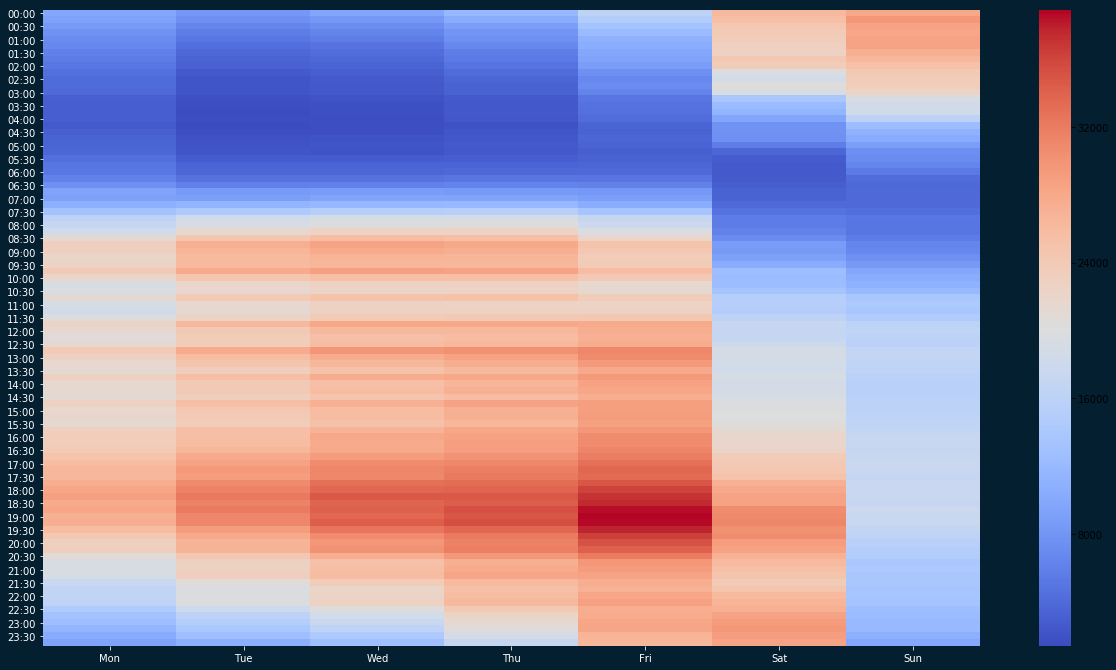

In [50]:
fig_hm = plt.figure(figsize=(21, 11.7))
fig_hm.patch.set_facecolor('#041F30')

ax = sns.heatmap(time_map, annot=False, xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                 cmap='coolwarm')                # , cbar_kws={'label':'Taxi Demand'})
plt.title('')                                     #Taxi demand by 15min time period by weekday
ax.set(xlabel='', ylabel='');                     #Pickup Weekday     #Pickup Time
ax.tick_params(colors='w', labelcolor='w')


# plt.savefig('Taxi_Demand_Heatmap.png', bbox_inches='tight');

In [294]:
#Let's create 7 lags
demand = pd.DataFrame(demand_over_time_diffed)
demand.rename(columns={'trip_start_timestamp': 'demand'}, inplace=True)
demand = demand.reset_index()
demand = demand.set_index(['trip_start_timestamp'])

#Create lags
demand['demand_lag1'] = demand['demand'].shift(1)
demand['demand_lag2'] = demand['demand'].shift(2)
demand['demand_lag3'] = demand['demand'].shift(3)
demand['demand_lag4'] = demand['demand'].shift(4)
demand['demand_lag5'] = demand['demand'].shift(5)
demand['demand_lag6'] = demand['demand'].shift(6)
demand['demand_lag7'] = demand['demand'].shift(7)
demand['demand_lag96'] = demand['demand'].shift(96)
demand['demand_lag672'] = demand['demand'].shift(672)

In [295]:
demand = demand.dropna()

In [296]:
demand.head(3)

,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,,
2016-01-12 00:15:00,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,-2.0
2016-01-12 01:30:00,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,0.0,-1.0
2016-01-12 05:15:00,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0


**Separating out a dataset for testing**

In [297]:
demand_jan_mar = demand[(demand.index >= pd.to_datetime('2016-01-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-03-31 23:59:59'))]
demand_jan_mar = demand_jan_mar.dropna()

demand_apr = demand[(demand.index >= pd.to_datetime('2016-04-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-04-30 23:59:59'))]
demand_apr = demand_apr.dropna()

demand_apr_may = demand[(demand.index >= pd.to_datetime('2016-04-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-05-31 23:59:59'))]
demand_apr_may = demand_apr_may.dropna()

In [298]:
# print(demand_jan_mar.head(5))
demand_apr.tail(5)

,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,,
2016-04-30 22:30:00,-3.0,2.0,-1.0,1.0,-2.0,3.0,0.0,-4.0,-1.0,1.0
2016-04-30 22:45:00,1.0,-3.0,2.0,-1.0,1.0,-2.0,3.0,0.0,1.0,1.0
2016-04-30 23:00:00,0.0,1.0,-3.0,2.0,-1.0,1.0,-2.0,3.0,2.0,0.0
2016-04-30 23:30:00,1.0,0.0,1.0,-3.0,2.0,-1.0,1.0,-2.0,-4.0,-1.0
2016-04-30 23:45:00,2.0,1.0,0.0,1.0,-3.0,2.0,-1.0,1.0,2.0,1.0


In [299]:
#Manual train-test split
lagged_demand, target_demand = demand_jan_mar.iloc[:, 1:], demand_jan_mar.iloc[:, 0]
test_lagged_demand, test_actual_demand = demand_apr.iloc[:, 1:], demand_apr.iloc[:, 0]

LR_demand = LinearRegression()
LR_demand.fit(lagged_demand, target_demand)

predicted_demand = LR_demand.predict(test_lagged_demand)

In [300]:
R2_score = LR_demand.score(test_lagged_demand, test_actual_demand)
MSE = mean_squared_error(test_actual_demand, predicted_demand)
RMSE = np.sqrt(MSE)

print(f'R2 score: {round(R2_score, 2)}')
print(f'RMSE score: {round(RMSE, 2)}')

R2 score: 0.42
RMSE score: 1.33


In [301]:
test_actual_demand.describe()

count    1976.000000
mean        0.000506
std         1.752105
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: demand, dtype: float64

Scores with 7 lags:
                     * R2 score: 0.26
                     * RMSE score: 35.95
                     
Scores with 7 lags & 96th:
                     * R2 score: 0.34
                     * RMSE score: 33.81
                     
Scores with 7 lags & 96th & 672nd:
                     * R2 score: 0.41
                     * RMSE score: 32.0

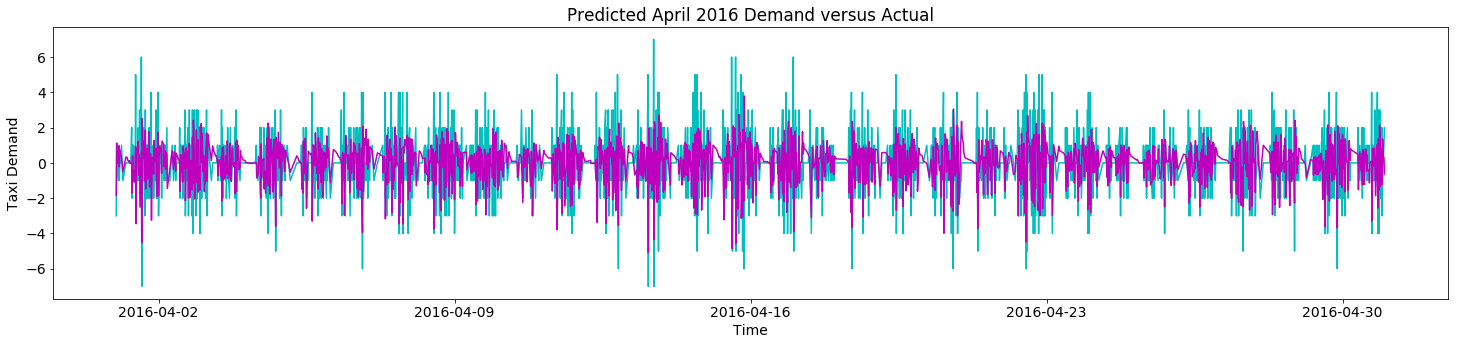

In [302]:
plt.figure(figsize=(25, 5))
plt.plot(test_actual_demand.index, test_actual_demand, color='c')
plt.plot(test_actual_demand.index, predicted_demand, color='m')
plt.title('Predicted April 2016 Demand versus Actual')
plt.xlabel('Time')
plt.ylabel('Taxi Demand');

### Trying out Facebook's Prophet, just for fun

In [158]:
# know_it_all = Prophet()
# know_it_all.fit(demand_jan_mar)

In [159]:
# future = know_it_all.make_future_dataframe(period=96)
# future.tail(3)

In [160]:
# forecast = know_it_all.predict(future)
# forecast[['trip_start_timestamp', 'yhat', 'yhat_lower', 'yhat_higher']].tail(5)

In [161]:
# future_predictions = know_it_all.plot(forecast)

### Final prep for modelling

In [303]:
#Creating trip_start_timestamp column for merging
demand = demand.reset_index()

In [304]:
demand.head()

,trip_start_timestamp,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
0,2016-01-12 00:15:00,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,-2.0
1,2016-01-12 01:30:00,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,0.0,-1.0
2,2016-01-12 05:15:00,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0
3,2016-01-12 07:00:00,2.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0
4,2016-01-12 07:30:00,-2.0,2.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0,1.0


## Merge original dataset with the demand dataframe

In [305]:
#Creating the final dataset
taxi_weather_final = taxi_weather_clean

In [306]:
#Adding demand variable in (joining on the trip_start_timestamp)
taxi_weather_final = taxi_weather_final.merge(demand, how='left', on='trip_start_timestamp')
taxi_weather_final = taxi_weather_final.dropna()

In [307]:
# taxi_weather_final = taxi_weather_final.dropna()

In [308]:
taxi_weather_final.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
0,2016-08-22 09:45:00,2016-08-22 10:00:00,480.0,1.0,6.75,Cash,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.880994,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016-07-18 08:15:00,2016-07-18 08:15:00,420.0,0.7,6.75,Cash,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,...,2.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0


#### Log distance and target variables

In [309]:
#Given previous analysis, miles, seconds and fare variables all have right-skewed distribution, to fix that I'm logging those three variables
taxi_weather_final['log_trip_miles'] = np.log(taxi_weather_final['trip_miles'])
taxi_weather_final['log_trip_seconds'] = np.log(taxi_weather_final['trip_seconds'])
taxi_weather_final['log_fare_with_tolls'] = np.log(taxi_weather_final['fare_with_tolls'])

#Convert the timestamp to a float
taxi_weather_final['current_time'] = [time_stamp.timestamp() for time_stamp in taxi_weather_final['trip_start_timestamp']]

In [310]:
taxi_weather_final.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672,log_trip_miles,log_trip_seconds,log_fare_with_tolls,current_time
0,2016-08-22 09:45:00,2016-08-22 10:00:00,480.0,1.0,6.75,Cash,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.880994,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,6.173786,1.909543,1.471859e+09
1,2016-07-18 08:15:00,2016-07-18 08:15:00,420.0,0.7,6.75,Cash,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,...,0.0,0.0,0.0,-1.0,0.0,-1.0,-0.356675,6.040255,1.909543,1.468830e+09


### Explore exogenious variables

In [311]:
taxi_smaller = taxi_weather_final[['trip_start_timestamp', 'trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                          'avg_temp_f', 'fog', 'rain', 'snow', 'trip_seconds', 'fare_with_tolls']]

In [312]:
taxi_weather_Sept = taxi_smaller[(taxi_smaller['trip_start_timestamp'] >= '2016-09-01 00:00:00') &
                                         (taxi_smaller['trip_start_timestamp'] <= '2016-09-15 23:59:59')]


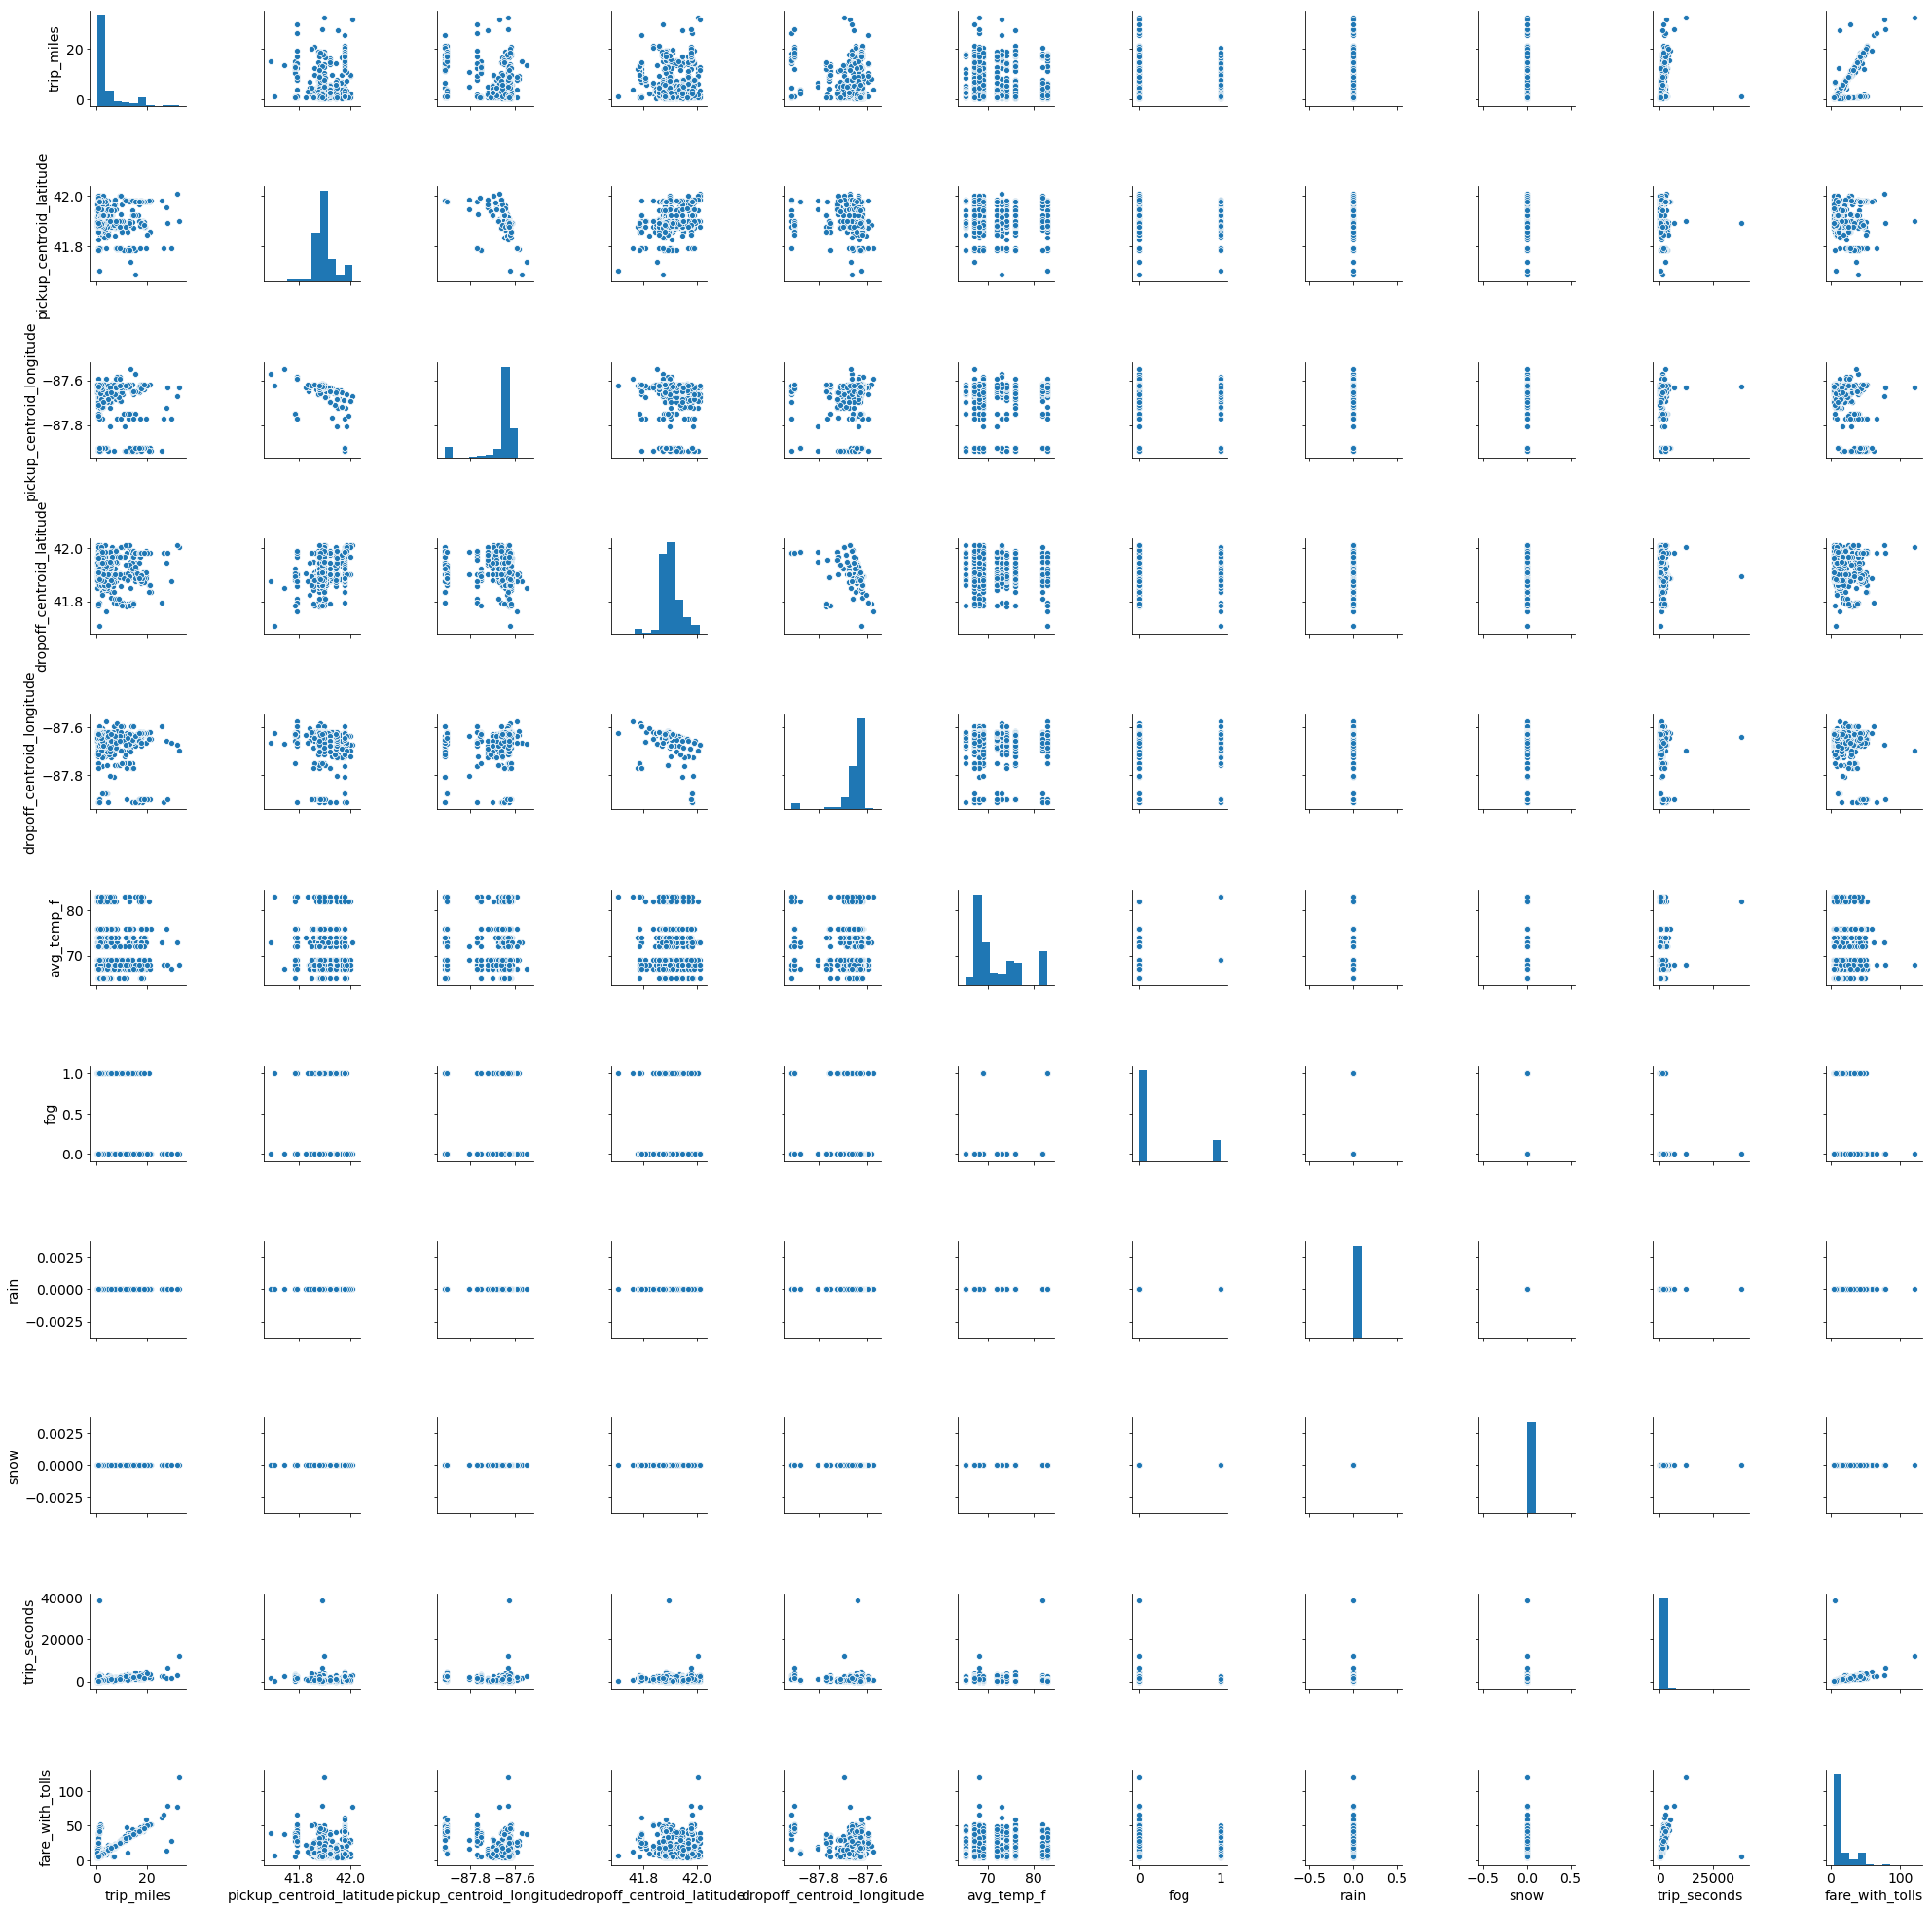

In [313]:
sns.pairplot(taxi_weather_Sept)

### Define features and target

In [314]:
#Define features and target variable for trip duration prediction
features_duration = taxi_weather_final[['demand_lag1', 'demand_lag2', 'demand_lag3', 'demand_lag4', 'demand_lag5', 'demand_lag6', 'demand_lag7', 'demand_lag96', 'demand_lag672', 'pickup_weekday', 
                               'log_trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                               'avg_temp_f', 'fog', 'rain', 'snow']]  #'avg_daily_wind_speed'
target_duration_log = taxi_weather_final['log_trip_seconds'] #taxi_weather_final[fare_with_tolls]


In [315]:
#Define features and target variable for fare prediction
features_fare = taxi_weather_final[['demand_lag1', 'demand_lag2', 'demand_lag3', 'demand_lag4', 'demand_lag5', 'demand_lag6', 'demand_lag7', 'demand_lag96', 'demand_lag672', 'pickup_weekday', 
                               'log_trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                               'avg_temp_f', 'fog', 'rain', 'snow']]  #'avg_daily_wind_speed'
target_fare_log = taxi_weather_final['log_fare_with_tolls'] #taxi_weather_final[fare_with_tolls]


### Scale the data

In [316]:
#Scale the values to 0 and 1 scale
scaler = StandardScaler()
scaled_features_duration = scaler.fit_transform(features_duration)


In [317]:
#Scale the values to 0 and 1 scale
scaler = StandardScaler()
scaled_features_fare = scaler.fit_transform(features_fare)


## In search for the best model

#### Helper functions

In [175]:

def simple_Kfold(features, target, model):
    """Performs a KFold cross-validation.
    Returns the average Root Mean Squared Error score."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features.iloc[train]
        y_train = target.iloc[train]
        X_test = features.iloc[test]
        y_test = target.iloc[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)
        
        #Get the mean squared error score
        mse = mean_squared_error(y_test_predict, np.exp(y_test))
        
        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2 = r2_score(y_test_predict, np.exp(y_test))
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]

def Kfold_for_logged_target(features, target, model):
    """Performs a KFold cross-validation.
    Returns RMSE and R2 scores."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features.iloc[train]
        y_train = target.iloc[train]
        X_test = features.iloc[test]
        y_test = target.iloc[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)        
        #Get the mean squared error score
        mse = mean_squared_error(np.exp(y_test_predict), np.exp(y_test))

        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2 = r2_score(np.exp(y_test_predict), np.exp(y_test))
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]
    

## Parameter search - ETA

In [318]:
LinReg_ETA = LinearRegression()
LinReg_ETA.fit(scaled_features_duration, target_duration_log);

In [319]:
mse_scores = cross_val_score(LinReg_ETA, scaled_features_duration, target_duration_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_ETA = LinReg_ETA.score(scaled_features_duration, target_duration_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR * 100, 1))+ '%', 'green')+'.')

Best RMSE score for Linear Regression cross validation is 44.4%.
Best r-squared score for Linear Regression cross validation is 66.6%.


> RMSE for Linear Regression is **44.4%** and R2 - **66.6%** (*on 150k record sample*).

In [220]:
#Ridge
# alphas = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0]   #[1e-5, 1e-4, 1e-3, 1e-2, 0.1, already tested
# max_iters = [100, 1000, 2000]    # already tested

# ridge_params = dict(alpha=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0],
#                     max_iter=[10, 20, 50, 100, 1000, 2000])

# grid_Ridge = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error')
# grid_Ridge.fit(scaled_features_duration, target_duration_log);

In [221]:
# examine the best model
# print('Best RMSE score for Ridge cross validation is', colored(str(round(np.sqrt(abs(grid_Ridge.best_score_)) * 100, 1))+'%', 'green')+ '.')
# print('Best parameters for Ridge cross validation are:\n\t', colored(str(grid_Ridge.best_params_), 'green'))
# print('Best estimators for Ridge cross validation are the following:\n\t', colored(str(grid_Ridge.best_estimator_), 'green'))

Best RMSE score for Ridge cross validation is 44.4%.
Best parameters for Ridge cross validation are:
	 {'alpha': 10.0, 'max_iter': 10}
Best estimators for Ridge cross validation are the following:
	 Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=10,
   normalize=False, random_state=None, solver='auto', tol=0.001)


**Best RMSE score for Ridge** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Ridge** cross validation are: **{'alpha': 30.0, 'max_iter': 100}**  
**Best estimators for Ridge** cross validation are the following: Ridge(alpha=30.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001)  

In [222]:
# # #Lasso
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0] #Tried out
# max_iters = [100, 1000, 2000]  #Tried out

# params_lasso = dict(alpha=alphas,
#                         max_iter=max_iters)

# grid_Lasso = GridSearchCV(Lasso(), param_grid=params_lasso, scoring='neg_mean_squared_error')
# grid_Lasso.fit(scaled_features_duration, target_duration_log);

In [223]:
# examine the best model
# print('Best RMSE score for Lasso cross validation is', colored(str(round(np.sqrt(abs(grid_Lasso.best_score_)), 3)), 'green')+ '.')
# print('Best parameters for Lasso cross validation are:\n\t', colored(str(grid_Lasso.best_params_), 'green'))
# print('Best estimators for Lasso cross validation are the following:\n\t', colored(str(grid_Lasso.best_estimator_), 'green'))

Best RMSE score for Lasso cross validation is 0.444.
Best parameters for Lasso cross validation are:
	 {'alpha': 1e-05, 'max_iter': 100}
Best estimators for Lasso cross validation are the following:
	 Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


**Best RMSE score for Lasso** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Lasso** cross validation are: **{'alpha': 1e-05, 'max_iter': 100}**  
**Best estimators for Lasso** cross validation are the following: Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [320]:
#RandomForest
params_randomForest = dict(n_estimators=[150, 175, 200, 225],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[35, 50, 55, 60, 65],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[1, 2, 3, 5, 10],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_ETA = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='neg_mean_squared_error')
grid_RandomForest_ETA.fit(scaled_features_duration, target_duration_log);

KeyboardInterrupt: 

In [ ]:
# examine the best model
print('Best RMSE score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_ETA.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_ETA.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_ETA.best_estimator_), 'green'))

**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 150k record sample*).    
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 35, 'min_samples_leaf': 3, 'n_estimators': 225}**  
**Best estimators for RandomForest** cross validation are the following: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                                                                           max_features='auto', max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=3, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=1,
                                                                           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
#XGBoost
params_XGBoost_ETA = dict(loss=['ls', 'lad', 'huber'],
                     learning_rate=[0.001, 1.0, 10.0],                                  #[0.001, 0.01, 0.1, 1.0, 10.0],
                     n_estimators=[5, 50, 250],                      #[5, 20, 50, 100, 150, 200, 250],
                     criterion=['mse'],
                     max_depth=[3, 35, 75],                                                   #[3, 5, 10, 15, 35, 50, 75],
                     min_samples_leaf=[5, 50, 200],                        #[2, 5, 10, 50, 100, 500, 1000],
                     random_state=[42])

grid_XGBoost_ETA = GridSearchCV(GradientBoostingRegressor(), param_grid=params_XGBoost, scoring='neg_mean_squared_error')
grid_XGBoost_ETA.fit(scaled_features_duration, target_duration_log);

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  outpu

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
 

In [ ]:
# examine the best model
print('Best RMSE score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_ETA.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_ETA.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_ETA.best_estimator_), 'green'))

**Best RMSE score for XGBoost** cross validation is **%** (*on 150k record sample without demand or time of day*).    
**Best parameters for XGBoost** cross validation are: ** **  
**Best estimators for XGBoost** cross validation are the following: Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001) 

### Now that I know the best parameters, let's see which model performs the best

In [ ]:
# model_list_ETA = [LinearRegression(),
#               RandomForestRegressor(n_estimators=225, max_depth=35, min_samples_leaf=3, random_state=42),
#               GradientBoostingRegressor(, random_state=42)]

# model_names_ETA = ['LinearRegression_ETA', 'RandomForest_ETA', 'XGBoost_ETA']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list_ETA)):
#     try_model = model_list_ETA[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names_ETA[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names_ETA[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names_ETA[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

### Feature importance using Random Forest

In [ ]:
# feat_imp = []
# for var, imp in zip([f for f in scaled_features.columns], Random_Forest.feature_importances_):
#     feat_imp.append((var, round(imp, 3)))

# for var, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
#     print(str(var)+':', str(imp))

## Parameter search - FARE

In [ ]:
LinReg_fare = LinearRegression()
LinReg_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
mse_scores = cross_val_score(LinReg_fare, scaled_features_fare, target_fare_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_fare = LinReg_fare.score(scaled_features_fare, target_fare_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR_fare * 100, 1))+ '%', 'green')+'.')

> RMSE for Linear Regression is **27.4%** and R2 - **83.6%** (*on 150k record sample*).

In [ ]:
#RandomForest
params_randomForest = dict(n_estimators=[150, 175, 200, 225],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[35, 50, 55, 60, 65],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[1, 2, 3, 5, 10],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_fare = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='neg_mean_squared_error')
grid_RandomForest_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
# examine the best model
print('Best RMSE score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_fare.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_fare.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_fare.best_estimator_), 'green'))

**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 150k record sample*).    
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}**  
**Best estimators for RandomForest** cross validation are the following: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                                                                           max_features='auto', max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=2, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
                                                                           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
#XGBoost
params_XGBoost_fare = dict(loss=['ls', 'lad', 'huber'],
                     learning_rate=[0.001, 1.0, 10.0],                                  #[0.001, 0.01, 0.1, 1.0, 10.0],
                     n_estimators=[5, 50, 250],                      #[5, 20, 50, 100, 150, 200, 250],
                     criterion=['mse'],
                     max_depth=[3, 35, 75],                                                   #[3, 5, 10, 15, 35, 50, 75],
                     min_samples_leaf=[5, 50, 200],                        #[2, 5, 10, 50, 100, 500, 1000],
                     random_state=[42])

grid_XGBoost_fare = GridSearchCV(GradientBoostingRegressor(), param_grid=params_XGBoost, scoring='neg_mean_squared_error')
grid_XGBoost_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
# examine the best model
print('Best RMSE score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_fare.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_fare.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_fare.best_estimator_), 'green'))

In [ ]:
# model_list_fare = [LinearRegression(),
#               Ridge(alpha=10.0, max_iter=10),
#               Lasso(alpha=1e-05, max_iter=100),
#               RandomForestRegressor(n_estimators=200, max_depth=50, min_samples_leaf=2, random_state=42),
#               GradientBoostingRegressor(, random_state=42)]

# model_names_fare = ['LinearRegression_fare', 'RandomForest_fare', 'XGBoost_fare']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list)):
#     try_model = model_list[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

## Finally! Mapping and visualizing :)

In [ ]:
def get_latitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    latitude = geocoder.osm(address).latlng[0]
    return latitude

def get_longitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    longitude = geocoder.osm(address).latlng[1]
    return longitude

def get_geopoint(address):
    """Takes an address string and converts it into a geopoint.
    Returns a geopoint."""
    geopoint = Point((get_longitude(address), get_latitude(address)))
    return geopoint

def get_distance(origin_address, destination_address):
    """Takes origin and destination addresses, converts them into geopoints and returns distance (in miles).
    Returns distance float (in miles)."""
    origin = (get_latitude(origin_address), get_longitude(origin_address))
    destination = (get_latitude(destination_address), get_longitude(destination_address))
    distance = gd.geodesic(origin, destination).miles
    return distance
    
def get_ETA(trip_duration, start_time=dt.datetime.now()):
    """Takes current datetime and trip duration as input.
    Returns Estimated Time of Arrival."""
    now = start_time
    return now + dt.timedelta(seconds=trip_duration)

def plot_route(origin, destination):
    """Takes origin and destination coordinates and generates a route on Chicago City map.
    Returns a plot with origin and destination marked as well the optimal route highlighted."""
    
    

In [ ]:
# my_date = pd.to_datetime('2018-01-01 10:00:00')
# print(get_ETA(3600))

In [ ]:
# print(get_now())

In [ ]:
# o_address = '149 new montgomery street, san francisco'
# d_address = '971 howard street, san francisco'
# print(get_latitude(o_address))
# print(get_longitude(o_address))
# print(get_geopoint(o_address))

> Need to remove those stupid messages!

In [ ]:
# get_distance(o_address, d_address)

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
# pickup_geopoint = list(zip(taxi_weather_clean['pickup_centroid_longitude'], taxi_weather_clean['pickup_centroid_latitude']))
# dropoff_geopoint = list(zip(taxi_weather_clean['dropoff_centroid_longitude'], taxi_weather_clean['dropoff_centroid_latitude']))

# taxi_weather_clean['pickup_centroid_location'] = pickup_geopoint
# taxi_weather_clean['dropoff_centroid_location'] = dropoff_geopoint

# taxi_weather_clean['pickup_centroid_location'] = taxi_weather_clean['pickup_centroid_location'].apply(Point)
# taxi_weather_clean['dropoff_centroid_location'] = taxi_weather_clean['dropoff_centroid_location'].apply(Point);


In [ ]:
# taxi_weather_clean.head(2)

In [ ]:
# taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_clean, geometry='pickup_centroid_location')

In [ ]:
# taxi_weather_gdf.tail(3)

In [ ]:
# with fiona.drivers():
#     with fiona.open("./Datasets/USA_adm/USA_adm2.shp") as source:
#         meta = source.meta
#         geoms = []
#         for fear in source:
#             geoms.append(fear['geometry'])

In [ ]:
# geoms[1]

In [ ]:
# # usa_shape_link = "./Datasets/LKA_adm/LKA_adm1.shp"
# geo_df = gpd.GeoDataFrame(geoms)
# geo_df.head()

In [ ]:
# geo_df.plot()

In [62]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = geo_df.plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()
# Place map
import gmplot
gmap = gmplot.GoogleMapPlotter(37.766956, -122.438481, 13)

# # Marker
hidden_gem_lat, hidden_gem_lon = 37.770776, -122.461689
gmap.scatter([hidden_gem_lat], [hidden_gem_lon],'cornflowerblue', size=40, marker=False)

# # Draw
gmap.draw("my_map.html")


# taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
# plt.title('Pickup locations')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude');

In [63]:
%%HTML
<iframe width="100%" height="650" src="./my_map.html"></iframe>